In [1]:
import pandas as pd
import sqlite3
from pathlib import Path
import matplotlib.pyplot as plt


In [2]:
# Load all datasets
providers   = pd.read_csv("providers_data.csv")
receivers   = pd.read_csv("receivers_data.csv")
food_listings = pd.read_csv("food_listings_data.csv")
claims      = pd.read_csv("claims_data.csv")

# Parse dates
food_listings["Expiry_Date"] = pd.to_datetime(food_listings["Expiry_Date"], errors="coerce").dt.date
claims["Timestamp"] = pd.to_datetime(claims["Timestamp"], errors="coerce")

# Preview
providers.head(), receivers.head(), food_listings.head(), claims.head()


(   Provider_ID                         Name           Type  \
 0            1             Gonzales-Cochran    Supermarket   
 1            2  Nielsen, Johnson and Fuller  Grocery Store   
 2            3                 Miller-Black    Supermarket   
 3            4   Clark, Prince and Williams  Grocery Store   
 4            5               Coleman-Farley  Grocery Store   
 
                                              Address            City  \
 0  74347 Christopher Extensions\nAndreamouth, OK ...     New Jessica   
 1           91228 Hanson Stream\nWelchtown, OR 27136     East Sheena   
 2  561 Martinez Point Suite 507\nGuzmanchester, W...  Lake Jesusview   
 3     467 Bell Trail Suite 409\nPort Jesus, IA 61188     Mendezmouth   
 4  078 Matthew Creek Apt. 319\nSaraborough, MA 53978   Valentineside   
 
                 Contact  
 0       +1-600-220-0480  
 1  +1-925-283-8901x6297  
 2      001-517-295-2206  
 3      556.944.8935x401  
 4          193.714.6577  ,
    Receiver_ID  

In [4]:
db_path = Path("foodwaste.db")

# Close old connection if exists
try:
    con.close()
except:
    pass

# Delete old DB if exists
if db_path.exists():
    db_path.unlink()


In [5]:
# Connect
con = sqlite3.connect(db_path)
cur = con.cursor()
cur.execute("PRAGMA foreign_keys = ON;")

# Create schema
cur.executescript("""
DROP TABLE IF EXISTS claims;
DROP TABLE IF EXISTS food_listings;
DROP TABLE IF EXISTS receivers;
DROP TABLE IF EXISTS providers;

CREATE TABLE providers (
    Provider_ID INTEGER PRIMARY KEY,
    Name TEXT NOT NULL,
    Type TEXT NOT NULL,
    Address TEXT,
    City TEXT,
    Contact TEXT
);

CREATE TABLE receivers (
    Receiver_ID INTEGER PRIMARY KEY,
    Name TEXT NOT NULL,
    Type TEXT NOT NULL,
    City TEXT,
    Contact TEXT
);

CREATE TABLE food_listings (
    Food_ID INTEGER PRIMARY KEY,
    Food_Name TEXT NOT NULL,
    Quantity INTEGER NOT NULL,
    Expiry_Date DATE,
    Provider_ID INTEGER NOT NULL,
    Provider_Type TEXT,
    Location TEXT,
    Food_Type TEXT,
    Meal_Type TEXT,
    FOREIGN KEY (Provider_ID) REFERENCES providers(Provider_ID)
        ON UPDATE CASCADE ON DELETE CASCADE
);

CREATE TABLE claims (
    Claim_ID INTEGER PRIMARY KEY,
    Food_ID INTEGER NOT NULL,
    Receiver_ID INTEGER NOT NULL,
    Status TEXT CHECK (Status IN ('Pending','Completed','Cancelled')),
    Timestamp DATETIME,
    FOREIGN KEY (Food_ID) REFERENCES food_listings(Food_ID)
        ON UPDATE CASCADE ON DELETE CASCADE,
    FOREIGN KEY (Receiver_ID) REFERENCES receivers(Receiver_ID)
        ON UPDATE CASCADE ON DELETE CASCADE
);
""")

# Insert data
providers.to_sql("providers", con, if_exists="append", index=False)
receivers.to_sql("receivers", con, if_exists="append", index=False)
food_listings.to_sql("food_listings", con, if_exists="append", index=False)
claims.to_sql("claims", con, if_exists="append", index=False)

con.commit()
print("✅ Database created with ON DELETE CASCADE")


✅ Database created with ON DELETE CASCADE


In [6]:
def run_query(query, params=None):
    return pd.read_sql_query(query, con, params=params or {})



In [7]:
# 1) Providers by city
run_query("SELECT City, COUNT(*) AS providers_count FROM providers GROUP BY City ORDER BY providers_count DESC LIMIT 10")

# 2) Receivers by city
run_query("SELECT City, COUNT(*) AS receivers_count FROM receivers GROUP BY City ORDER BY receivers_count DESC LIMIT 10")

# 3) Top provider types by food quantity
run_query("""
SELECT p.Type, SUM(f.Quantity) AS total_quantity
FROM food_listings f
JOIN providers p ON p.Provider_ID = f.Provider_ID
GROUP BY p.Type
ORDER BY total_quantity DESC
""")

# 4) Claims by status
run_query("SELECT Status, COUNT(*) AS count FROM claims GROUP BY Status")


,Status,count
0,Cancelled,336
1,Completed,339
2,Pending,325


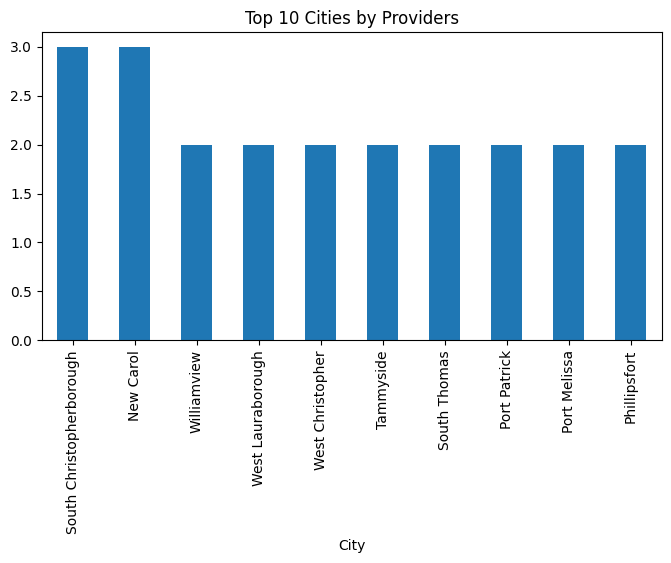

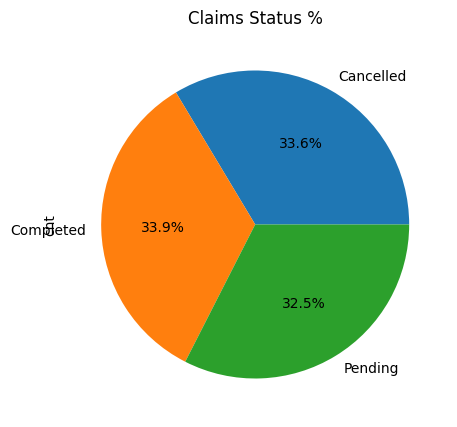

In [8]:
# Providers by city (bar chart)
df = run_query("SELECT City, COUNT(*) AS cnt FROM providers GROUP BY City ORDER BY cnt DESC LIMIT 10")
df.plot(kind="bar", x="City", y="cnt", legend=False, figsize=(8,4), title="Top 10 Cities by Providers")
plt.show()

# Claims by Status (pie chart)
df = run_query("SELECT Status, COUNT(*) AS cnt FROM claims GROUP BY Status")
df.plot(kind="pie", y="cnt", labels=df["Status"], autopct='%1.1f%%', figsize=(5,5), legend=False, title="Claims Status %")
plt.show()


In [9]:
# CREATE - Add new listing
cur.execute("""
INSERT INTO food_listings (Food_Name, Quantity, Expiry_Date, Provider_ID, Provider_Type, Location, Food_Type, Meal_Type)
VALUES (?, ?, ?, ?, ?, ?, ?, ?)
""", ("Rice Packets", 25, "2025-08-25", 1, "Supermarket", "Delhi", "Vegetarian", "Dinner"))
con.commit()
print("✅ New listing added")

# READ - Fetch listings
run_query("SELECT * FROM food_listings LIMIT 5")

# UPDATE - Update quantity
cur.execute("UPDATE food_listings SET Quantity=? WHERE Food_ID=?", (50, 1))
con.commit()
print("✅ Quantity updated")

# DELETE - Delete listing (cascade deletes related claims automatically)
cur.execute("DELETE FROM food_listings WHERE Food_ID=?", (1,))
con.commit()
print("✅ Listing and related claims deleted")


✅ New listing added
✅ Quantity updated
✅ Listing and related claims deleted


In [11]:
# CREATE claim
from datetime import datetime
cur.execute("""
INSERT INTO claims (Food_ID, Receiver_ID, Status, Timestamp)
VALUES (?, ?, ?, ?)
""", (2, 5, "Pending", datetime.now()))
con.commit()

# UPDATE claim
cur.execute("UPDATE claims SET Status=? WHERE Claim_ID=?", ("Completed", 1))
con.commit()

# READ claims
run_query("SELECT * FROM claims ORDER BY Claim_ID DESC LIMIT 5")


,Claim_ID,Food_ID,Receiver_ID,Status,Timestamp
0,1001,2,5,Pending,2025-08-19 17:48:46.891146
1,1000,596,950,Cancelled,2025-03-13 12:51:00
2,999,917,90,Completed,2025-03-01 15:31:00
3,998,832,967,Cancelled,2025-03-13 18:00:00
4,997,980,746,Cancelled,2025-03-17 22:04:00


In [12]:
run_query("""
SELECT Location AS City, COUNT(*) AS total_listings
FROM food_listings
GROUP BY Location
ORDER BY total_listings DESC
LIMIT 5
""")


,City,total_listings
0,South Kathryn,6
1,New Carol,6
2,Perezport,5
3,Jimmyberg,5
4,East Angela,5


In [13]:
run_query("""
SELECT Food_Type, COUNT(*) AS total
FROM food_listings
GROUP BY Food_Type
ORDER BY total DESC
""")


,Food_Type,total
0,Vegetarian,337
1,Vegan,334
2,Non-Vegetarian,329


In [14]:
run_query("""
SELECT r.Name, COUNT(c.Claim_ID) AS claims_count
FROM claims c
JOIN receivers r ON r.Receiver_ID = c.Receiver_ID
GROUP BY r.Name
ORDER BY claims_count DESC
LIMIT 5
""")


,Name,claims_count
0,William Frederick,5
1,Scott Hunter,5
2,Matthew Webb,5
3,Anthony Garcia,5
4,Kristine Martin,4


In [15]:
run_query("""
SELECT p.Name, SUM(f.Quantity) AS total_quantity
FROM food_listings f
JOIN providers p ON p.Provider_ID = f.Provider_ID
GROUP BY p.Name
ORDER BY total_quantity DESC
LIMIT 5
""")


,Name,total_quantity
0,Miller Inc,217
1,Barry Group,179
2,"Evans, Wright and Mitchell",158
3,Smith Group,150
4,Campbell LLC,145


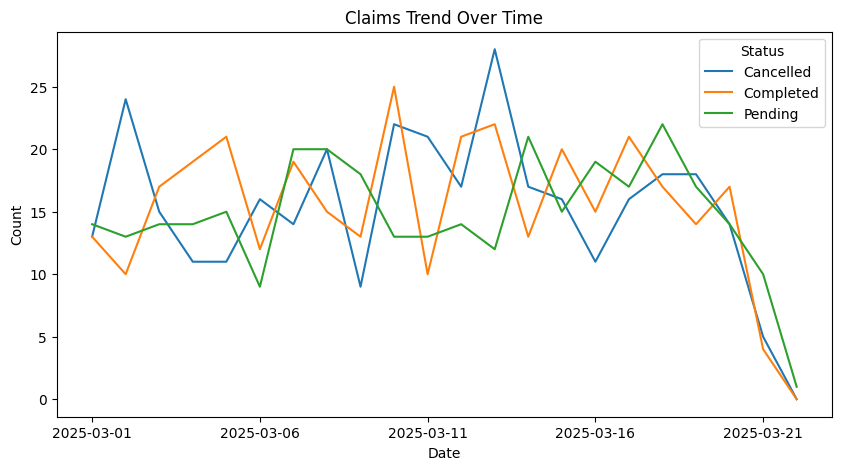

In [16]:
df = run_query("""
SELECT DATE(Timestamp) AS Date, Status, COUNT(*) AS cnt
FROM claims
GROUP BY Date, Status
ORDER BY Date
""")

df.pivot(index="Date", columns="Status", values="cnt").fillna(0).plot(kind="line", figsize=(10,5))
plt.title("Claims Trend Over Time")
plt.ylabel("Count")
plt.show()


In [17]:
con.commit()
con.close()
print("✅ Database saved at", db_path)


✅ Database saved at foodwaste.db
